In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:
azeri_light = pd.read_excel('data/decomposition/azeri_light.xlsx')
brent = pd.read_excel('data/decomposition/brent.xls')
gdp = pd.read_csv('data/decomposition/gdp.csv')
loan_history = pd.read_csv('data/decomposition/loan_history.csv')


In [3]:
loan_history.rename(columns={'T_DMCREDITSUM':'loan_amount'},inplace=True)
loan_history['T_BDBEGINDATE'] = pd.to_datetime(loan_history['T_BDBEGINDATE'])
loan_history['month'] = loan_history['T_BDBEGINDATE'].dt.to_period('M')
loan_history['quarter'] = loan_history['T_BDBEGINDATE'].dt.to_period('Q')
loan_history['year'] = loan_history['T_BDBEGINDATE'].dt.year
loan_history = loan_history.query("year>=2020").sort_values('T_BDBEGINDATE')
loan_history = loan_history.groupby('quarter',as_index=False)['loan_amount'].sum()

azeri_light['Day'] = pd.to_datetime(azeri_light['Day'])
azeri_light['year']=azeri_light['Day'].dt.year
azeri_light['quarter'] = azeri_light['Day'].dt.to_period('Q')
azeri_light = azeri_light.query("year>=2020").sort_values('Day')

brent['Date'] = pd.to_datetime(brent['Date'])
brent['year'] = brent['Date'].dt.year
brent['quarter'] = brent['Date'].dt.to_period('Q')
brent = brent.query("year>=2020").sort_values('Date')

gdp.rename(columns={'Year':'year'},inplace=True)


azeri_q = azeri_light[['quarter', 'Azeri_Light']].rename(columns={'Azeri_Light': 'amount'})
brent_q = brent[['quarter', 'price']].rename(columns={'price': 'amount'}).copy()
loan_q = loan_history[['quarter', 'loan_amount']].rename(columns={'loan_amount': 'amount'})


In [4]:
# Merge quarterly dataframes: aggregate azeri and brent by quarter (mean), keep loan amounts, then merge
azeri_q_agg = azeri_q.groupby('quarter', as_index=False)['amount'].mean().rename(columns={'amount': 'azeri_avg'})
brent_q_agg = brent_q.groupby('quarter', as_index=False)['amount'].mean().rename(columns={'amount': 'brent_avg'})
loan_q_agg = loan_q.rename(columns={'amount': 'loan_amount'})

merged_quarterly = azeri_q_agg.merge(brent_q_agg, on='quarter', how='outer') \
                              .merge(loan_q_agg, on='quarter', how='outer') \
                              .sort_values('quarter') \
                              .reset_index(drop=True)

merged_quarterly

,quarter,azeri_avg,brent_avg,loan_amount
0,2020Q1,53.074844,50.440000,4.747011e+07
1,2020Q2,32.699016,29.343333,1.658392e+07
2,2020Q3,45.912308,42.963333,5.202839e+07
3,2020Q4,47.316462,44.290000,2.701383e+07
4,2021Q1,63.568889,60.820000,5.351918e+07
5,2021Q2,71.181803,68.833333,7.509509e+07
6,2021Q3,75.709077,73.470000,7.148343e+07
7,2021Q4,81.382500,79.586667,7.906455e+07
8,2022Q1,102.394219,100.296667,7.295831e+07
9,2022Q2,115.335246,113.543333,1.049932e+08


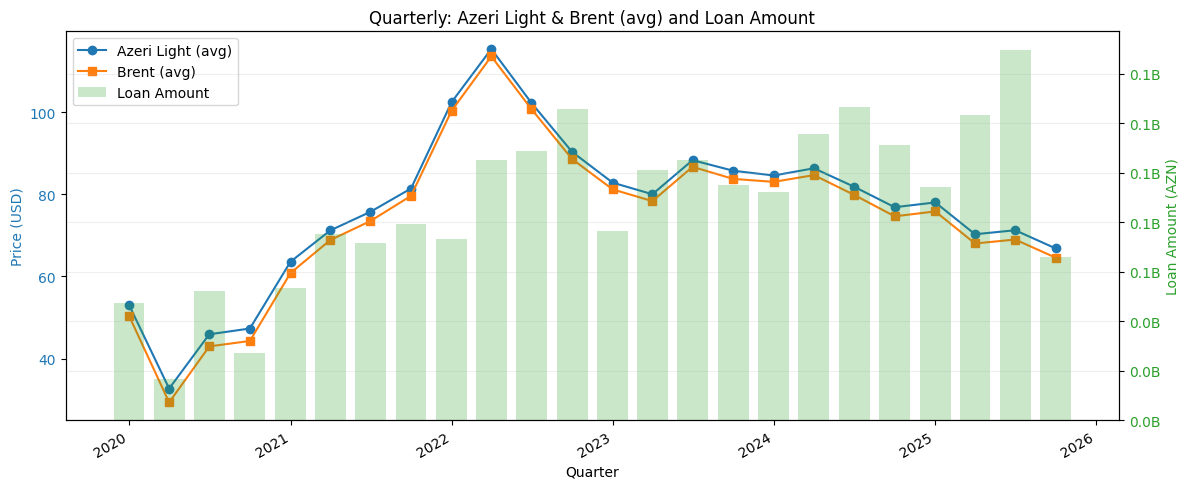

In [15]:
# visualize merged_quarterly: lines for azeri_avg & brent_avg, secondary axis bars for loan_amount
df_plot = merged_quarterly.copy()
df_plot['quarter_start'] = df_plot['quarter'].dt.to_timestamp()

import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(df_plot['quarter_start'], df_plot['azeri_avg'],
         marker='o', label='Azeri Light (avg)', color='tab:blue')
ax1.plot(df_plot['quarter_start'], df_plot['brent_avg'],
         marker='s', label='Brent (avg)', color='tab:orange')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Price (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
# show bars only where loan_amount is present
ax2.bar(df_plot['quarter_start'], df_plot['loan_amount'].fillna(0),
        width=70, alpha=0.25, color='tab:green', label='Loan Amount')
ax2.set_ylabel('Loan Amount (AZN)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e9:.1f}B'))

# legend, formatting
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.autofmt_xdate()
plt.title('Quarterly: Azeri Light & Brent (avg) and Loan Amount')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()